In [1]:
import pandas as pd
import os

# Specify the folder containing the CSV files
folder_path = "/home/snucse/Desktop/archive"  # Update if necessary

# List of CSV filenames
files = [
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv"
]

df_list = []
missing_files = []

# Load available files
for file in files:
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        print(f"Loading: {file}")
        df = pd.read_csv(file_path, low_memory=False)
        df_list.append(df)
    else:
        print(f"File not found: {file_path}")
        missing_files.append(file)

# Check if any data was loaded
if df_list:
    combined_df = pd.concat(df_list, axis=0, ignore_index=True)
    output_file = os.path.join(folder_path, "CICIDS_combined_dataset.csv")
    combined_df.to_csv(output_file, index=False)
    print(f"Combined dataset saved to {output_file}")
else:
    print("No files were loaded. Please check the file paths and dataset availability.")

# Show missing files
if missing_files:
    print("The following files were not found:")
    for missing in missing_files:
        print(missing)


Loading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loading: Friday-WorkingHours-Morning.pcap_ISCX.csv
Loading: Monday-WorkingHours.pcap_ISCX.csv
Loading: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loading: Tuesday-WorkingHours.pcap_ISCX.csv
Loading: Wednesday-workingHours.pcap_ISCX.csv
Combined dataset saved to /home/snucse/Desktop/archive/CICIDS_combined_dataset.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
# Step 2: Check for any missing values
df = df.dropna()  # Drop rows with missing values

# Step 3: Encode the 'Label' column (normal vs attack)
df[' Label'] = df[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)

# Step 4: Select relevant features (drop 'Label' as it's the target)
X = df.drop(' Label', axis=1).values
y = df[' Label'].values

# Step 5: Replace inf and handle large values
X = np.where(np.isinf(X), np.nan, X)  # Replace inf with NaN
X = np.nan_to_num(X, nan=np.nanmean(X))  # Replace NaNs with column mean

# Step 6: Standardize the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader for IID setup (optional)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 8: Simulating Non-IID Data Split for Clients
def split_noniid_data(X, y, num_clients):
    """
    Split data in a non-IID fashion among clients.
    Each client gets data with biased label distributions.
    """
    non_iid_data = []
    unique_labels = np.unique(y)
    
    # Split data by labels
    label_indices = {label: np.where(y == label)[0] for label in unique_labels}
    
    for client_id in range(num_clients):
        client_data_indices = []
        for label in unique_labels:
            # Each client gets a portion of data for each label (biased distribution)
            num_samples = int(len(label_indices[label]) / num_clients)
            selected_indices = np.random.choice(label_indices[label], num_samples, replace=False)
            client_data_indices.extend(selected_indices)
            
            # Remove selected indices to avoid overlap between clients
            label_indices[label] = np.setdiff1d(label_indices[label], selected_indices)
        
        # Add the client's data to the list
        client_data_X = X[client_data_indices]
        client_data_y = y[client_data_indices]
        non_iid_data.append((client_data_X, client_data_y))
    
    return non_iid_data

# Simulate 12 clients with non-IID data
num_clients = 12
client_data_splits = split_noniid_data(X_train, y_train, num_clients)

# Example of how to convert each client's data to PyTorch tensors
client_datasets = []
for client_data_X, client_data_y in client_data_splits:
    client_X_tensor = torch.tensor(client_data_X, dtype=torch.float32)
    client_y_tensor = torch.tensor(client_data_y, dtype=torch.long)
    client_datasets.append(TensorDataset(client_X_tensor, client_y_tensor))

# Print client data sizes for verification
for i, dataset in enumerate(client_datasets):
    print(f"Client {i+1} data size: {len(dataset)} samples")


/tmp/ipykernel_10230/1571340517.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Label'] = df[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)


Client 1 data size: 46112 samples
Client 2 data size: 42270 samples
Client 3 data size: 38747 samples
Client 4 data size: 35518 samples
Client 5 data size: 32558 samples
Client 6 data size: 29845 samples
Client 7 data size: 27358 samples
Client 8 data size: 25078 samples
Client 9 data size: 22989 samples
Client 10 data size: 21072 samples
Client 11 data size: 19317 samples
Client 12 data size: 17706 samples


In [2]:
!pip install torch


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 18.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.0 MB/s eta 0:00:0031m75.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 11.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 18.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 31.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
print("Feature shape:", X_train.shape)


Feature shape: (553356, 78)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch.utils.data import DataLoader
import torch.nn.functional as F
from opacus import PrivacyEngine  # Differential Privacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [9]:
!pip install opacus


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 24.3 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_channels=1, output_size=2, input_length=41):  # Corrected __init__
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        
        # Calculate the flattened size after convolution
        self.fc_input_dim = 32 * input_length  # Adjust if pooling is added
        
        self.fc1 = nn.Linear(self.fc_input_dim, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        if x.ndim == 2:  # If shape is [batch_size, features]
            x = x.unsqueeze(1)  # Add a channel dimension: [batch_size, 1, features]
        elif x.ndim == 4:  # If shape is [batch_size, 1, 1, features]
            x = x.squeeze(2)  # Remove the extra dimension: [batch_size, 1, features]

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [5]:
def adversarial_attack(model, data, target, epsilon=0.1): #999
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    perturbed_data = data + epsilon * data.grad.sign()
    return perturbed_data.detach()

In [6]:
class Client:
    def __init__(self, client_id, model, dataset, lr=0.001, mu=0.1, epsilon=0.2, delta=1e-5):
        self.client_id = client_id
        self.model = copy.deepcopy(model)
        self.dataset = dataset
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.mu = mu
        self.epsilon = epsilon
        self.delta = delta
        self.privacy_engine = PrivacyEngine()
        self.model, self.optimizer, self.dataloader = self.privacy_engine.make_private(
            module=self.model,
            optimizer=self.optimizer,
            data_loader=self.dataloader,
            noise_multiplier=0.3,
            max_grad_norm=1.5
        )
        self.grad_tracker = [torch.zeros_like(param) for param in self.model.parameters()]

    def train_local(self, global_model, epochs=1, adv_training=True, fkd=True):
        self.model.train()
        global_params = list(global_model.parameters())

        for epoch in range(epochs):
            for data, target in self.dataloader:
                data, target = data.to(torch.float32), target.to(torch.long)
                if adv_training:
                    data = adversarial_attack(self.model, data, target)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)

                if fkd:
                    with torch.no_grad():
                        global_output = global_model(data)
                    distill_loss = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(output, dim=1), F.softmax(global_output, dim=1)
                    )
                    loss += 0.4 * distill_loss

                loss.backward()
                self.optimizer.step()

        # Update the client’s historical gradient (FedDyn)
        with torch.no_grad():
            for i, (param, g_param) in enumerate(zip(self.model.parameters(), global_params)):
                self.grad_tracker[i] -= self.mu * (param.detach() - g_param.detach())

        return self.model.state_dict()


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.num_clients = num_clients
        self.clients = []

    def register_client(self, client):
        self.clients.append(client)

    def aggregate_weights(self, client_weights):
        avg_weights = copy.deepcopy(client_weights[0])
        for key in avg_weights.keys():
            avg_weights[key] = torch.stack([client_weight[key] for client_weight in client_weights]).mean(dim=0)
        clean_weights = {key.replace("_module.", ""): value for key, value in avg_weights.items()}
        return clean_weights

    def federated_training(self, rounds=10, epochs=1, adv_training=True, fkd=True):
        for r in range(rounds):
            selected_clients = self.clients
            client_weights = [client.train_local(self.global_model, epochs, adv_training, fkd) for client in selected_clients]
            aggregated_weights = self.aggregate_weights(client_weights)
            self.global_model.load_state_dict(aggregated_weights)
            print(f'Round {r + 1} completed.')

    def evaluate_model(self, test_loader):
        self.global_model.eval()
        y_true, y_pred = [], []
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.float32), target.to(torch.long)
                output = self.global_model(data)
                loss = criterion(output, target)
                total_loss += loss.item()
                predictions = torch.argmax(output, dim=1)
                y_true.extend(target.numpy())
                y_pred.extend(predictions.numpy())
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        return accuracy, precision, recall, f1


In [8]:
server_model = CNN(input_channels=1, output_size=2, input_length=X_train.shape[1])
server = Server(server_model, num_clients)

In [9]:
for i in range(num_clients):
    client = Client(i, server_model, client_datasets[i])
    server.register_client(client)

/home/snucse/.local/lib/python3.11/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [ ]:
server.federated_training(rounds=35, epochs=5, adv_training=True)

/home/snucse/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Evaluation Metrics:
Accuracy: 0.9392
Precision: 0.9373
Recall: 0.9305
F1 Score: 0.9337


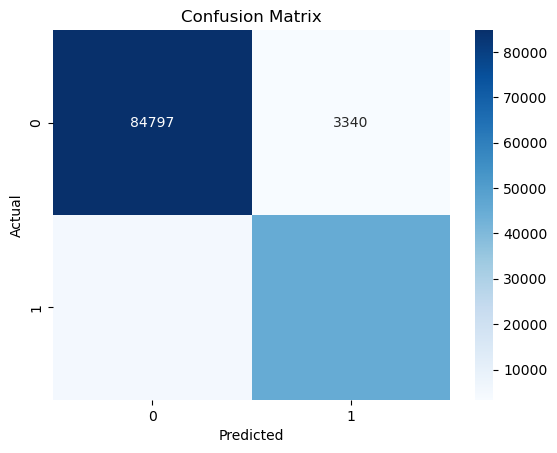

(0.9391928523409885,
 0.9373268464857163,
 0.9305363098119847,
 0.9337455087140931)

In [12]:
server.evaluate_model(DataLoader(test_dataset, batch_size=32, shuffle=False))